In [2]:
#!pip install numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 7.2 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 33.9 MB/s eta 0:00:0000:0100:01


In [3]:
import numpy as np
from numba import jit  # Para optimización adicional

In [19]:


class ParticleFilter:
    def __init__(self, n_particles, x0, Q):
        self.n_particles = n_particles
        self.Q = Q
        
        # Inicializar partículas usando operación vectorizada
        self.particles = np.random.multivariate_normal(x0, Q, n_particles)
        self.weights = np.ones(n_particles) / n_particles
        
        # Preparar matrices para cálculos
        self.R_inv = np.linalg.inv(R)  # Calcular una vez
        
    @staticmethod
    @jit(nopython=True)  # Acelerar función del modelo
    def f(x, u):
        """Modelo no lineal del sistema vectorizado"""
        theta = x[:, 0]
        theta_dot = x[:, 1]
        
        dtheta = theta_dot
        dtheta_dot = (-b*theta_dot - m*g*l*np.sin(theta) + u)/(m*l**2)
        
        result = np.empty((x.shape[0], 2))
        result[:, 0] = theta + T * dtheta
        result[:, 1] = theta_dot + T * dtheta_dot
        return result
    
    def predict(self, u):
        # Propagar todas las partículas de una vez
        self.particles = self.f(self.particles, u)
        
        # Añadir ruido vectorizado
        self.particles += np.random.multivariate_normal(
            np.zeros(2), 
            self.Q, 
            self.n_particles
        )
        
        # Retornar estimación ponderada
        return np.average(self.particles, weights=self.weights, axis=0)
    
    def update(self, z, R):
        # Calcular diferencias para todas las partículas de una vez
        diff = z - self.particles  # Shape: (n_particles, 2)
        
        # Calcular productos matriciales vectorizados
        quad_term = np.sum(diff @ self.R_inv * diff, axis=1)
        
        # Actualizar pesos usando operación vectorizada
        log_weights = -0.5 * quad_term
        weights_new = np.exp(log_weights - np.max(log_weights))  # Evitar underflow
        
        # Normalizar pesos
        self.weights = weights_new / np.sum(weights_new)
        
        # Calcular número efectivo de partículas
        N_eff = 1.0 / np.sum(np.square(self.weights))
        
        # Resampling sistemático cuando sea necesario
        if N_eff < self.n_particles/2:
            cumsum = np.cumsum(self.weights)
            cumsum[-1] = 1.0  # Evitar errores de redondeo
            
            # Generar puntos de muestreo uniformes
            positions = (np.random.random() + np.arange(self.n_particles)) / self.n_particles
            
            # Encontrar índices usando searchsorted vectorizado
            indices = np.searchsorted(cumsum, positions)
            
            # Realizar resampling
            self.particles = self.particles[indices]
            self.weights[:] = 1.0 / self.n_particles  # Asignación vectorizada
        
        return np.average(self.particles, weights=self.weights, axis=0)

    def get_state_distribution(self):
        """Retorna media y covarianza del estado estimado"""
        mean = np.average(self.particles, weights=self.weights, axis=0)
        cov = np.cov(self.particles.T, aweights=self.weights)
        return mean, cov

# Ejemplo de uso con monitoreo de tiempo
import time


# Parámetros del sistema
m = 1.0     # masa (kg)
l = 1.0     # longitud (m)
g = 9.81    # gravedad (m/s²)
b = 0.1     # fricción (N⋅m⋅s/rad)

# Inicialización
x0 = np.array([np.pi/4, 0])
Q = np.diag([0.001, 0.001])
R = np.diag([0.04, 0.04])
pf = ParticleFilter(n_particles=1000, x0=x0, Q=Q)

# Parámetros de simulación
T = 0.01    # período de muestreo (s)
t_final = 10  # tiempo final de simulación (s)
k_steps = int(t_final/T)  # número de pasos
n_edos = 2  # número de ecuaciones diferenciales
t = np.arange(0, t_final, T)  # vector de tiempo

# Vectores para almacenar resultados
theta_pf = np.zeros(k_steps)
theta_dot_pf = np.zeros(k_steps)
execution_times = np.zeros(k_steps)

theta_ruido = np.zeros(k_steps)      # ángulo
theta_ruido_dot = np.zeros(k_steps)  # velocidad angular
theta_ruido[0] = np.pi/4    # 45 grados
theta_ruido_dot[0] = 0      # velocidad inicial cero


def control_retroalimentacion(estado, t):
    #theta_ref = np.sin(t)
    #dtheta_ref = np.cos(t)  
    #ddtheta_ref = -np.sin(t)  
    theta_ref = 1/(np.exp(5 - t) + 1) #np.sin(t)
    dtheta_ref = np.exp(5 - t)/(np.exp(5 - t) + 1)**2 #np.cos(t)
    ddtheta_ref = (-np.exp(5 - t) + 2*np.exp(10 - 2*t)/(np.exp(5 - t) + 1))/(np.exp(5 - t) + 1)**2 #-np.sin(t) 
    
    theta,dtheta = estado+ np.random.normal(0,0.002,(estado.shape) )
    k1,k2 = 10,20 #2,1
    
    e = theta - theta_ref  # Error
    de = dtheta - dtheta_ref  # Derivada del error

    u = m*l**2*( ddtheta_ref - k1*(de) -k2*(e) + (b/(m*l**2))*dtheta + (g/l)*np.sin(theta) )  # Control
    return u  


# Simulación con medición de tiempo
for k in range(k_steps):
    start_time = time.time()
    
    # Medición con ruido
    z = np.array([theta_ruido[k], theta_ruido_dot[k]])
    
    # Predicción y actualización
    u = control_retroalimentacion(z, t[k])
    x_pf = pf.predict(u)
    x_pf = pf.update(z, R)
    
    # Guardar resultados
    theta_pf[k] = x_pf[0]
    theta_dot_pf[k] = x_pf[1]
    
    execution_times[k] = time.time() - start_time

print(f"Tiempo promedio por iteración: {np.mean(execution_times)*1000:.2f} ms")
print(f"Tiempo total: {np.sum(execution_times):.2f} s")

Tiempo promedio por iteración: 2.00 ms
Tiempo total: 2.00 s


In [16]:
import numpy as np

# Crear dos matrices 1D
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])

# Apilar las matrices verticalmente
result = np.vstack((a, b))
print(result)

result = np.stack((a, b),axis=1)
print(result)

[[1 2 3]
 [4 5 6]]
[[1 4]
 [2 5]
 [3 6]]


In [20]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

class AdaptiveParticleFilter:
    def __init__(self, num_particles=1000):
        # Parámetros del sistema
        self.m = 1.0
        self.l = 1.0
        self.b = 0.1
        self.g = 9.81
        
        # Parámetros del filtro
        self.num_particles = num_particles
        self.dt = 0.01
        self.Q = np.diag([0.001, 0.001])  # Covarianza inicial del proceso
        self.R = np.array([[0.1]])        # Covarianza inicial de medición
        
        # Parámetros UKF para propagación
        self.n = 2  # dimensión del estado
        self.alpha = 0.001  # parámetro de dispersión
        self.beta = 2.0     # distribución gaussiana óptima
        self.kappa = 0.0    # parámetro secundario de dispersión
        self.lambda_ = self.alpha**2 * (self.n + self.kappa) - self.n
        
        # Pesos UKF
        self.weights_m = np.zeros(2 * self.n + 1)
        self.weights_c = np.zeros(2 * self.n + 1)
        self._compute_sigma_weights()
        
        # Inicialización de partículas con mejor distribución
        self.particles = np.zeros((num_particles, 2))
        self.weights = np.ones(num_particles) / num_particles
        
        # Parámetros adaptativos
        self.Q_adapt = self.Q.copy()
        self.R_adapt = self.R.copy()
        self.innovation_history = []
        
    def _compute_sigma_weights(self):
        """Calcula los pesos para los puntos sigma"""
        self.weights_m[0] = self.lambda_ / (self.n + self.lambda_)
        self.weights_c[0] = self.lambda_ / (self.n + self.lambda_) + (1 - self.alpha**2 + self.beta)
        
        for i in range(1, 2 * self.n + 1):
            self.weights_m[i] = 1.0 / (2 * (self.n + self.lambda_))
            self.weights_c[i] = self.weights_m[i]
    
    def generate_sigma_points(self, mean, cov):
        """Genera puntos sigma usando la transformación unscented"""
        n = mean.shape[0]
        sigma_points = np.zeros((2 * n + 1, n))
        sigma_points[0] = mean
        
        # Calcular la raíz cuadrada de la matriz de covarianza
        U = np.linalg.cholesky((n + self.lambda_) * cov)
        
        for i in range(n):
            sigma_points[i + 1] = mean + U[i]
            sigma_points[n + i + 1] = mean - U[i]
            
        return sigma_points
    
    def system_dynamics(self, state, t, u):
        """Modelo no lineal del péndulo"""
        theta, theta_dot = state
        
        dtheta = theta_dot
        dtheta_dot = (-self.b/(self.m*self.l**2) * theta_dot - 
                      self.g/self.l * np.sin(theta) + 
                      1/(self.m*self.l**2) * u)
        
        return np.array([dtheta, dtheta_dot])
    
    def propagate_particle_ukf(self, particle, u):
        """Propaga una partícula usando UKF"""
        # Generar puntos sigma alrededor de la partícula
        sigma_points = self.generate_sigma_points(particle, self.Q_adapt)
        
        # Propagar cada punto sigma
        propagated_points = np.zeros_like(sigma_points)
        for i in range(sigma_points.shape[0]):
            solution = odeint(self.system_dynamics, 
                            sigma_points[i], 
                            [0, self.dt], 
                            args=(u,))
            propagated_points[i] = solution[-1]
        
        # Calcular media y covarianza propagadas
        mean = np.sum(self.weights_m.reshape(-1, 1) * propagated_points, axis=0)
        
        # Añadir ruido adaptativo
        return mean + np.random.multivariate_normal([0,0], self.Q_adapt)
    
    def propagate_particles(self, u):
        """Propaga todas las partículas"""
        for i in range(self.num_particles):
            self.particles[i] = self.propagate_particle_ukf(self.particles[i], u)
            # Normalizar ángulo
            self.particles[i,0] = (self.particles[i,0] + np.pi) % (2 * np.pi) - np.pi
    
    def update_adaptive_noise(self, innovation):
        """Actualiza adaptativamente las matrices de covarianza"""
        self.innovation_history.append(innovation)
        if len(self.innovation_history) > 50:  # Ventana de adaptación
            innovation_matrix = np.array(self.innovation_history[-50:])
            
            # Actualizar R adaptativo
            R_new = np.cov(innovation_matrix.T)
            if R_new.size == 1:
                R_new = np.array([[max(0.001, R_new)]])
            self.R_adapt = 0.95 * self.R_adapt + 0.05 * R_new
            
            # Actualizar Q adaptativo usando correlación de innovaciones
            innovation_diff = np.diff(innovation_matrix, axis=0)
            Q_new = np.cov(innovation_diff.T)
            if Q_new.size == 1:
                Q_new = np.diag([max(0.001, Q_new), max(0.001, Q_new)])
            self.Q_adapt = 0.95 * self.Q_adapt + 0.05 * Q_new
    
    def update_weights(self, measurement):
        """Actualiza los pesos usando kernel gaussiano adaptativo"""
        innovations = np.zeros(self.num_particles)
        
        for i in range(self.num_particles):
            innovations[i] = measurement - self.particles[i,0]
            
            # Usar kernel gaussiano con ancho adaptativo
            likelihood = multivariate_normal.pdf(innovations[i], 
                                              mean=0, 
                                              cov=self.R_adapt[0,0])
            
            self.weights[i] *= likelihood
        
        # Actualizar ruido adaptativo
        mean_innovation = np.average(innovations, weights=self.weights)
        self.update_adaptive_noise(mean_innovation)
        
        # Normalizar pesos
        weight_sum = np.sum(self.weights)
        if weight_sum > 0:
            self.weights /= weight_sum
        else:
            self.weights.fill(1.0 / self.num_particles)
    
    def systematic_resample(self):
        """Remuestreo sistemático mejorado"""
        positions = (np.random.random() + np.arange(self.num_particles)) / self.num_particles
        cumsum = np.cumsum(self.weights)
        cumsum[-1] = 1.0
        
        new_particles = np.zeros_like(self.particles)
        new_weights = np.zeros_like(self.weights)
        
        i = 0  # índice para positions
        j = 0  # índice para cumsum
        
        while i < self.num_particles:
            if positions[i] < cumsum[j]:
                new_particles[i] = self.particles[j]
                new_weights[i] = 1.0 / self.num_particles
                i += 1
            else:
                j += 1
        
        return new_particles, new_weights
    
    def estimate_state(self):
        """Estimación del estado usando media ponderada circular"""
        # Media circular para el ángulo
        mean_cos = np.sum(self.weights * np.cos(self.particles[:,0]))
        mean_sin = np.sum(self.weights * np.sin(self.particles[:,0]))
        mean_angle = np.arctan2(mean_sin, mean_cos)
        
        # Media normal para la velocidad angular
        mean_velocity = np.sum(self.weights * self.particles[:,1])
        
        return np.array([mean_angle, mean_velocity])
    
    def get_state_covariance(self):
        """Calcula la covarianza del estado estimado"""
        mean_state = self.estimate_state()
        cov = np.zeros((2, 2))
        
        for i in range(self.num_particles):
            diff = self.particles[i] - mean_state
            # Manejar la discontinuidad del ángulo
            diff[0] = np.arctan2(np.sin(diff[0]), np.cos(diff[0]))
            cov += self.weights[i] * np.outer(diff, diff)
            
        return cov
    
    def run_iteration(self, measurement, u=0):
        """Ejecuta una iteración completa del filtro"""
        # Propagar partículas
        self.propagate_particles(u)
        
        # Actualizar pesos
        self.update_weights(measurement)
        
        # Calcular número efectivo de partículas
        Neff = 1.0 / np.sum(self.weights**2)
        
        # Remuestreo si es necesario
        if Neff < self.num_particles/2:
            self.particles, self.weights = self.systematic_resample()
        
        # Retornar estimación y covarianza
        return self.estimate_state(), self.get_state_covariance()

# Ejemplo de uso y comparación con EKF
def simulate_and_compare():
    # Inicializar filtros
    pf = AdaptiveParticleFilter(num_particles=1000)
    
    # Tiempo de simulación
    t = np.arange(0, 10, pf.dt)
    
    # Arrays para almacenar resultados
    true_states = np.zeros((len(t), 2))
    pf_states = np.zeros((len(t), 2))
    measurements = np.zeros(len(t))
    
    # Estado inicial real
    true_states[0] = [np.pi/2, 0]  # 90 grados, sin velocidad inicial
    
    # Inicializar partículas con distribución más informativa
    pf.particles = np.random.normal(true_states[0], [0.1, 0.1], (pf.num_particles, 2))
    
    # Simulación
    for k in range(1, len(t)):
        # Control (péndulo libre)
        u = 0
        
        # Propagar estado verdadero
        solution = odeint(pf.system_dynamics, true_states[k-1], [0, pf.dt], args=(u,))
        true_states[k] = solution[-1]
        
        # Generar medición con ruido variable
        noise_scale = 0.1 * (1 + 0.5*np.sin(2*np.pi*t[k]/5))  # Ruido variable
        measurements[k] = true_states[k,0] + np.random.normal(0, noise_scale)
        
        # Actualizar filtro de partículas
        pf_states[k], _ = pf.run_iteration(measurements[k], u)
    
    return t, true_states, pf_states, measurements

# Ejecutar simulación y graficar resultados
t, true_states, pf_states, measurements = simulate_and_compare()

# Graficar resultados
plt.figure(figsize=(15, 10))

# Ángulo
plt.subplot(2,1,1)
plt.plot(t, true_states[:,0], 'k-', label='Verdadero', linewidth=2)
plt.plot(t, pf_states[:,0], 'r--', label='PF Mejorado', linewidth=2)
plt.plot(t, measurements, 'g.', label='Mediciones', alpha=0.5, markersize=2)
plt.ylabel('Ángulo (rad)')
plt.legend()
plt.grid(True)
plt.title('Comparación de Estimación del Ángulo')

# Velocidad angular
plt.subplot(2,1,2)
plt.plot(t, true_states[:,1], 'k-', label='Verdadero', linewidth=2)
plt.plot(t, pf_states[:,1], 'r--', label='PF Mejorado', linewidth=2)
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad angular (rad/s)')
plt.legend()
plt.grid(True)
plt.title('Comparación de Estimación de Velocidad Angular')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Tiempo de ejecución: 8.72 segundos


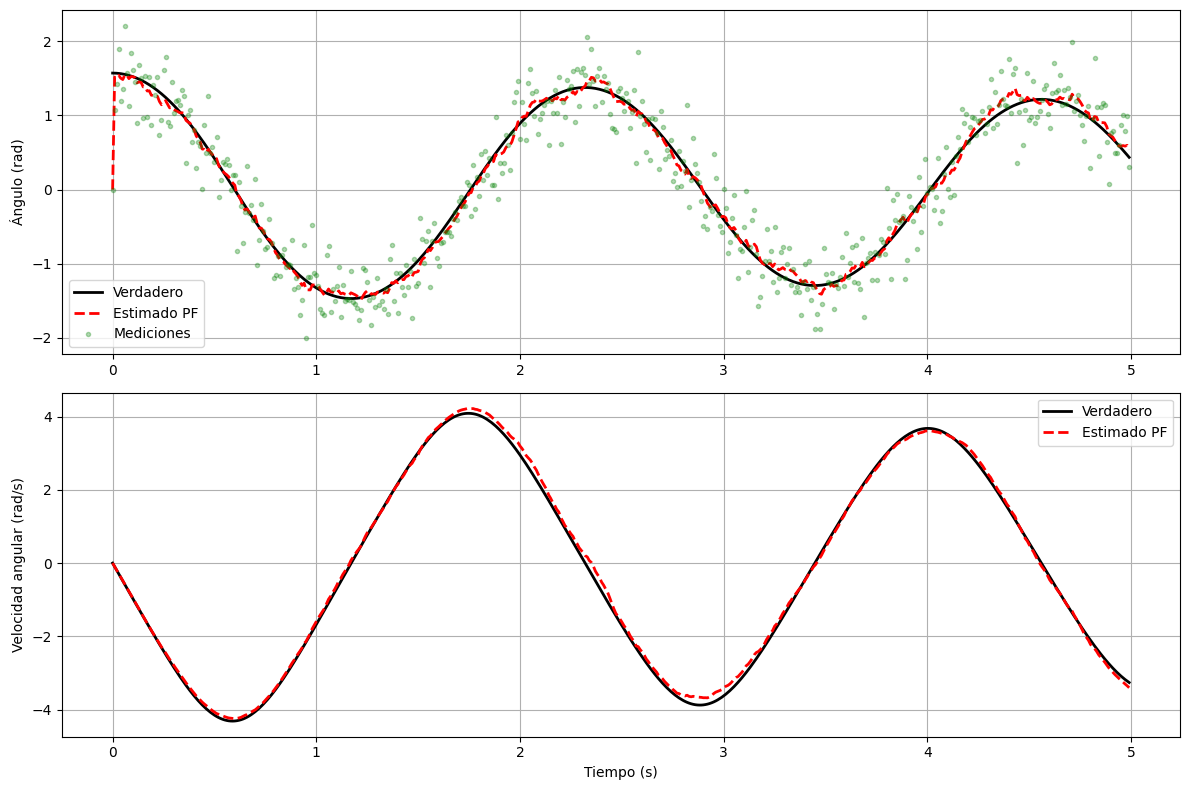

In [21]:
import numpy as np
from numba import jit, prange
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time

@jit(nopython=True)
def system_dynamics_numba(state, params):
    """Modelo del péndulo optimizado con Numba"""
    theta, theta_dot = state
    m, l, b, g, u = params
    
    dtheta = theta_dot
    dtheta_dot = (-b/(m*l**2) * theta_dot - 
                  g/l * np.sin(theta) + 
                  1/(m*l**2) * u)
    
    return np.array([dtheta, dtheta_dot])

@jit(nopython=True)
def rk4_step(state, dt, params):
    """Integrador Runge-Kutta 4 optimizado"""
    k1 = system_dynamics_numba(state, params)
    k2 = system_dynamics_numba(state + dt*k1/2, params)
    k3 = system_dynamics_numba(state + dt*k2/2, params)
    k4 = system_dynamics_numba(state + dt*k3, params)
    return state + dt*(k1 + 2*k2 + 2*k3 + k4)/6

class FastParticleFilter:
    def __init__(self, num_particles=1000):
        # Parámetros del sistema
        self.m = 1.0
        self.l = 1.0
        self.b = 0.1
        self.g = 9.81
        self.dt = 0.01
        
        # Parámetros del filtro
        self.num_particles = num_particles
        self.particles = np.zeros((num_particles, 2))
        self.weights = np.ones(num_particles) / num_particles
        
        # Matrices de covarianza precomputadas
        self.Q = np.diag([0.001, 0.001])
        self.R = 0.1
        
        # Cache para operaciones frecuentes
        self._sqrt_2pi_R = np.sqrt(2 * np.pi * self.R)
        self._2R = 2 * self.R
        
        # Precomputar parámetros del sistema para Numba
        self.system_params = np.array([self.m, self.l, self.b, self.g, 0.0])
        
    @staticmethod
    @jit(nopython=True, parallel=True)
    def propagate_particles_parallel(particles, params, dt, Q):
        """Propaga todas las partículas en paralelo"""
        n_particles = len(particles)
        new_particles = np.empty_like(particles)
        
        for i in prange(n_particles):
            # Integración RK4
            new_particles[i] = rk4_step(particles[i], dt, params)
            
            # Añadir ruido del proceso
            new_particles[i] += np.random.normal(0, np.sqrt(Q[0,0]), 2)
            
            # Normalizar ángulo
            new_particles[i,0] = (new_particles[i,0] + np.pi) % (2 * np.pi) - np.pi
            
        return new_particles
    
    @staticmethod
    @jit(nopython=True)
    def update_weights_fast(particles, weights, measurement, R_inv, sqrt_2pi_R):
        """Actualización de pesos vectorizada y optimizada"""
        # Calcular innovaciones
        innovations = measurement - particles[:,0]
        
        # Calcular likelihood usando forma vectorizada
        likelihood = np.exp(-0.5 * innovations**2 * R_inv) / sqrt_2pi_R
        
        # Actualizar y normalizar pesos
        weights *= likelihood
        weights /= np.sum(weights)
        
        return weights
    
    @staticmethod
    @jit(nopython=True)
    def systematic_resample_fast(particles, weights):
        """Remuestreo sistemático optimizado"""
        N = len(weights)
        positions = (np.random.random() + np.arange(N)) / N
        
        cumsum = np.cumsum(weights)
        cumsum[-1] = 1.0  # Evitar errores numéricos
        
        new_particles = np.empty_like(particles)
        
        i = 0
        j = 0
        while i < N:
            if positions[i] < cumsum[j]:
                new_particles[i] = particles[j]
                i += 1
            else:
                j += 1
                
        return new_particles, np.ones(N) / N
    
    @staticmethod
    @jit(nopython=True)
    def estimate_state_fast(particles, weights):
        """Estimación de estado optimizada"""
        # Media circular para el ángulo
        mean_cos = np.sum(weights * np.cos(particles[:,0]))
        mean_sin = np.sum(weights * np.sin(particles[:,0]))
        mean_angle = np.arctan2(mean_sin, mean_cos)
        
        # Media ponderada para velocidad
        mean_velocity = np.sum(weights * particles[:,1])
        
        return np.array([mean_angle, mean_velocity])
    
    def run_iteration(self, measurement, u=0):
        """Ejecuta una iteración completa del filtro optimizado"""
        # Actualizar parámetros del sistema
        self.system_params[4] = u
        
        # Propagar partículas
        self.particles = self.propagate_particles_parallel(
            self.particles, self.system_params, self.dt, self.Q)
        
        # Actualizar pesos
        self.weights = self.update_weights_fast(
            self.particles, self.weights, measurement, 1/self.R, self._sqrt_2pi_R)
        
        # Calcular número efectivo de partículas
        Neff = 1.0 / np.sum(self.weights**2)
        
        # Remuestreo si es necesario
        if Neff < self.num_particles/2:
            self.particles, self.weights = self.systematic_resample_fast(
                self.particles, self.weights)
        
        # Retornar estimación
        return self.estimate_state_fast(self.particles, self.weights)

def simulate_system():
    """Simula el sistema del péndulo"""
    # Crear instancia del filtro
    pf = FastParticleFilter(num_particles=1000)
    
    # Tiempo de simulación
    t = np.arange(0, 5, pf.dt)
    
    # Arrays para resultados
    true_states = np.zeros((len(t), 2))
    estimated_states = np.zeros((len(t), 2))
    measurements = np.zeros(len(t))
    
    # Estado inicial
    true_states[0] = [np.pi/2, 0]
    pf.particles = np.random.normal(true_states[0], [0.1, 0.1], 
                                  (pf.num_particles, 2))
    
    # Medir tiempo de ejecución
    start_time = time.time()
    
    # Simulación principal
    for k in range(1, len(t)):
        # Control
        u = 0
        
        # Propagar estado verdadero
        true_states[k] = rk4_step(true_states[k-1], pf.dt, 
                                 np.array([pf.m, pf.l, pf.b, pf.g, u]))
        
        # Generar medición
        measurements[k] = true_states[k,0] + np.random.normal(0, np.sqrt(pf.R))
        
        # Actualizar filtro
        estimated_states[k] = pf.run_iteration(measurements[k], u)
    
    execution_time = time.time() - start_time
    print(f"Tiempo de ejecución: {execution_time:.2f} segundos")
    
    return t, true_states, estimated_states, measurements

# Ejecutar simulación
t, true_states, estimated_states, measurements = simulate_system()

# Visualización
plt.figure(figsize=(12, 8))

# Ángulo
plt.subplot(2,1,1)
plt.plot(t, true_states[:,0], 'k-', label='Verdadero', linewidth=2)
plt.plot(t, estimated_states[:,0], 'r--', label='Estimado PF', linewidth=2)
plt.plot(t, measurements, 'g.', label='Mediciones', alpha=0.3)
plt.ylabel('Ángulo (rad)')
plt.legend()
plt.grid(True)

# Velocidad angular
plt.subplot(2,1,2)
plt.plot(t, true_states[:,1], 'k-', label='Verdadero', linewidth=2)
plt.plot(t, estimated_states[:,1], 'r--', label='Estimado PF', linewidth=2)
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad angular (rad/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
import numpy as np
from numba import jit, prange
import matplotlib.pyplot as plt
import time

# Añadiendo ruido de medicion

In [24]:


@jit(nopython=True)
def system_dynamics_numba(state, params):
    """Modelo del péndulo optimizado"""
    theta, theta_dot = state
    m, l, b, g, u = params
    
    dtheta = theta_dot
    dtheta_dot = (-b/(m*l**2) * theta_dot - 
                  g/l * np.sin(theta) + 
                  1/(m*l**2) * u)
    
    return np.array([dtheta, dtheta_dot])

@jit(nopython=True)
def rk4_step(state, dt, params):
    """Integrador RK4 optimizado"""
    k1 = system_dynamics_numba(state, params)
    k2 = system_dynamics_numba(state + dt*k1/2, params)
    k3 = system_dynamics_numba(state + dt*k2/2, params)
    k4 = system_dynamics_numba(state + dt*k3, params)
    return state + dt*(k1 + 2*k2 + 2*k3 + k4)/6

class AdaptiveParticleFilter:
    def __init__(self, num_particles=1000):
        # Parámetros del sistema
        self.m = 1.0
        self.l = 1.0
        self.b = 0.1
        self.g = 9.81
        self.dt = 0.01
        
        # Parámetros del filtro
        self.num_particles = num_particles
        self.particles = np.zeros((num_particles, 2))
        self.weights = np.ones(num_particles) / num_particles
        
        # Inicialización de Q y R adaptativos
        self.Q = np.diag([0.001, 0.001])
        self.R = 0.1
        
        # Parámetros para adaptación
        self.innovation_window = np.zeros((50, 1))  # Ventana de innovaciones
        self.window_size = 50
        self.window_idx = 0
        self.alpha_Q = 0.02  # Tasa de adaptación de Q
        self.alpha_R = 0.02  # Tasa de adaptación de R
        self.min_Q = 1e-6    # Valores mínimos para evitar degeneración
        self.min_R = 1e-6
        
        # Métricas de rendimiento
        self.innovation_mean = 0
        self.innovation_var = 1
        self.neff_history = []
        
        # Cache para optimización
        self._sqrt_2pi = np.sqrt(2 * np.pi)
        self.system_params = np.array([self.m, self.l, self.b, self.g, 0.0])
        
    @staticmethod
    @jit(nopython=True, parallel=True)
    def propagate_particles_parallel(particles, params, dt, Q_diag):
        """Propagación paralela de partículas con Q adaptativo"""
        n_particles = len(particles)
        new_particles = np.empty_like(particles)
        
        for i in prange(n_particles):
            # Integración RK4
            new_particles[i] = rk4_step(particles[i], dt, params)
            
            # Ruido del proceso adaptativo
            new_particles[i] += np.random.normal(0, np.sqrt(Q_diag))
            
            # Normalización del ángulo
            new_particles[i,0] = (new_particles[i,0] + np.pi) % (2 * np.pi) - np.pi
            
        return new_particles
    
    def update_Q(self, innovation):
        """Actualización adaptativa de Q basada en innovaciones"""
        # Actualizar ventana de innovaciones
        self.innovation_window[self.window_idx] = innovation
        self.window_idx = (self.window_idx + 1) % self.window_size
        
        if self.window_idx == 0:  # Ventana completa
            # Calcular estadísticas de la ventana
            innovation_var = np.var(self.innovation_window)
            
            # Ajustar Q basado en la varianza de innovaciones
            Q_new = np.maximum(innovation_var * np.eye(2), self.min_Q)
            
            # Actualización suave de Q
            self.Q = (1 - self.alpha_Q) * self.Q + self.alpha_Q * Q_new
    
    def update_R(self, innovation):
        """Actualización adaptativa de R basada en innovaciones"""
        # Calcular varianza de innovación a corto plazo
        innovation_var_short = innovation**2
        
        # Ajustar R basado en la varianza de innovación
        R_new = np.maximum(innovation_var_short, self.min_R)
        
        # Actualización suave de R
        self.R = (1 - self.alpha_R) * self.R + self.alpha_R * R_new
        
    @staticmethod
    @jit(nopython=True)
    def update_weights_fast(particles, weights, measurement, R):
        """Actualización de pesos optimizada"""
        innovations = measurement - particles[:,0]
        likelihood = np.exp(-0.5 * innovations**2 / R) / np.sqrt(2 * np.pi * R)
        weights *= likelihood
        weights /= np.sum(weights)
        return weights, innovations
    
    @staticmethod
    @jit(nopython=True)
    def systematic_resample_fast(particles, weights):
        """Remuestreo sistemático optimizado"""
        N = len(weights)
        positions = (np.random.random() + np.arange(N)) / N
        cumsum = np.cumsum(weights)
        cumsum[-1] = 1.0
        
        new_particles = np.empty_like(particles)
        i = 0
        j = 0
        while i < N:
            if positions[i] < cumsum[j]:
                new_particles[i] = particles[j]
                i += 1
            else:
                j += 1
                
        return new_particles, np.ones(N) / N
    
    def run_iteration(self, measurement, u=0):
        """Ejecuta una iteración completa del filtro adaptativo"""
        # Actualizar control en parámetros del sistema
        self.system_params[4] = u
        
        # Propagar partículas
        self.particles = self.propagate_particles_parallel(
            self.particles, self.system_params, self.dt, np.diag(self.Q))
        
        # Actualizar pesos y obtener innovaciones
        self.weights, innovations = self.update_weights_fast(
            self.particles, self.weights, measurement, self.R)
        
        # Actualizar Q y R adaptativos
        mean_innovation = np.mean(innovations)
        self.update_Q(mean_innovation)
        self.update_R(mean_innovation)
        
        # Calcular número efectivo de partículas
        Neff = 1.0 / np.sum(self.weights**2)
        self.neff_history.append(Neff)
        
        # Remuestreo adaptativo
        if Neff < self.num_particles/2:
            self.particles, self.weights = self.systematic_resample_fast(
                self.particles, self.weights)
        
        # Estimación del estado
        mean_cos = np.sum(self.weights * np.cos(self.particles[:,0]))
        mean_sin = np.sum(self.weights * np.sin(self.particles[:,0]))
        mean_angle = np.arctan2(mean_sin, mean_cos)
        mean_velocity = np.sum(self.weights * self.particles[:,1])
        
        return np.array([mean_angle, mean_velocity])

def simulate_system():
    """Simulación del sistema con monitoreo de Q y R"""
    pf = AdaptiveParticleFilter(num_particles=1000)
    t = np.arange(0, 5, pf.dt)
    
    # Arrays para almacenar resultados
    true_states = np.zeros((len(t), 2))
    estimated_states = np.zeros((len(t), 2))
    measurements = np.zeros(len(t))
    Q_history = np.zeros((len(t), 2))
    R_history = np.zeros(len(t))
    
    # Estado inicial
    true_states[0] = [np.pi/2, 0]
    pf.particles = np.random.normal(true_states[0], [0.1, 0.1], 
                                  (pf.num_particles, 2))
    
    # Simulación principal
    start_time = time.time()
    
    for k in range(1, len(t)):
        # Simular sistema
        true_states[k] = rk4_step(true_states[k-1], pf.dt, pf.system_params)
        
        # Generar medición con ruido variable
        noise_scale = 0.1 * (1 + 0.5*np.sin(2*np.pi*t[k]))
        measurements[k] = true_states[k,0] + np.random.normal(0, noise_scale)
        
        # Actualizar filtro
        estimated_states[k] = pf.run_iteration(measurements[k])
        
        # Guardar Q y R
        Q_history[k] = np.diag(pf.Q)
        R_history[k] = pf.R
    
    print(f"Tiempo de ejecución: {time.time() - start_time:.2f} segundos")
    
    return t, true_states, estimated_states, measurements, Q_history, R_history

# Ejecutar simulación
t, true_states, estimated_states, measurements, Q_history, R_history = simulate_system()

# Visualización
plt.figure(figsize=(15, 10))

# Estados
plt.subplot(3,1,1)
plt.plot(t, true_states[:,0], 'k-', label='Verdadero', linewidth=2)
plt.plot(t, estimated_states[:,0], 'r--', label='Estimado PF', linewidth=2)
plt.plot(t, measurements, 'g.', label='Mediciones', alpha=0.3)
plt.ylabel('Ángulo (rad)')
plt.legend()
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t, true_states[:,1], 'k-', label='Verdadero', linewidth=2)
plt.plot(t, estimated_states[:,1], 'r--', label='Estimado PF', linewidth=2)
plt.ylabel('Velocidad (rad/s)')
plt.legend()
plt.grid(True)

# Q y R adaptativos
plt.subplot(3,1,3)
plt.plot(t, Q_history[:,0], 'b-', label='Q[0,0]', alpha=0.7)
plt.plot(t, Q_history[:,1], 'g-', label='Q[1,1]', alpha=0.7)
plt.plot(t, R_history, 'r-', label='R', alpha=0.7)
plt.xlabel('Tiempo (s)')
plt.ylabel('Covarianzas')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in method normal of numpy.random.mtrand.RandomState object at 0x7df92c68a340>) found for signature:
 
 >>> normal(Literal[int](0), array(float64, 1d, C))
 
There are 8 candidate implementations:
    - Of which 4 did not match due to:
    Overload in function 'np_gauss_impl0': File: numba/cpython/randomimpl.py: Line 287.
      With argument(s): '(int64, array(float64, 1d, C))':
     Rejected as the implementation raised a specific error:
       TypingError: too many positional arguments
  raised from /home/michel/anaconda3/envs/General/lib/python3.12/site-packages/numba/core/typing/templates.py:783
    - Of which 2 did not match due to:
    Overload of function 'normal': File: numba/cpython/randomimpl.py: Line 299.
      With argument(s): '(int64, array(float64, 1d, C))':
     No match.
    - Of which 2 did not match due to:
    Overload in function 'np_gauss_impl3': File: numba/cpython/randomimpl.py: Line 328.
      With argument(s): '(int64, array(float64, 1d, C))':
     Rejected as the implementation raised a specific error:
       TypingError: missing a required argument: 'size'
  raised from /home/michel/anaconda3/envs/General/lib/python3.12/site-packages/numba/core/typing/templates.py:783

During: resolving callee type: Function(<built-in method normal of numpy.random.mtrand.RandomState object at 0x7df92c68a340>)
During: typing of call at /tmp/ipykernel_287587/701207635.py (71)


File "../../../../../tmp/ipykernel_287587/701207635.py", line 71:
<source missing, REPL/exec in use?>


Tiempo de ejecución: 5.22 segundos


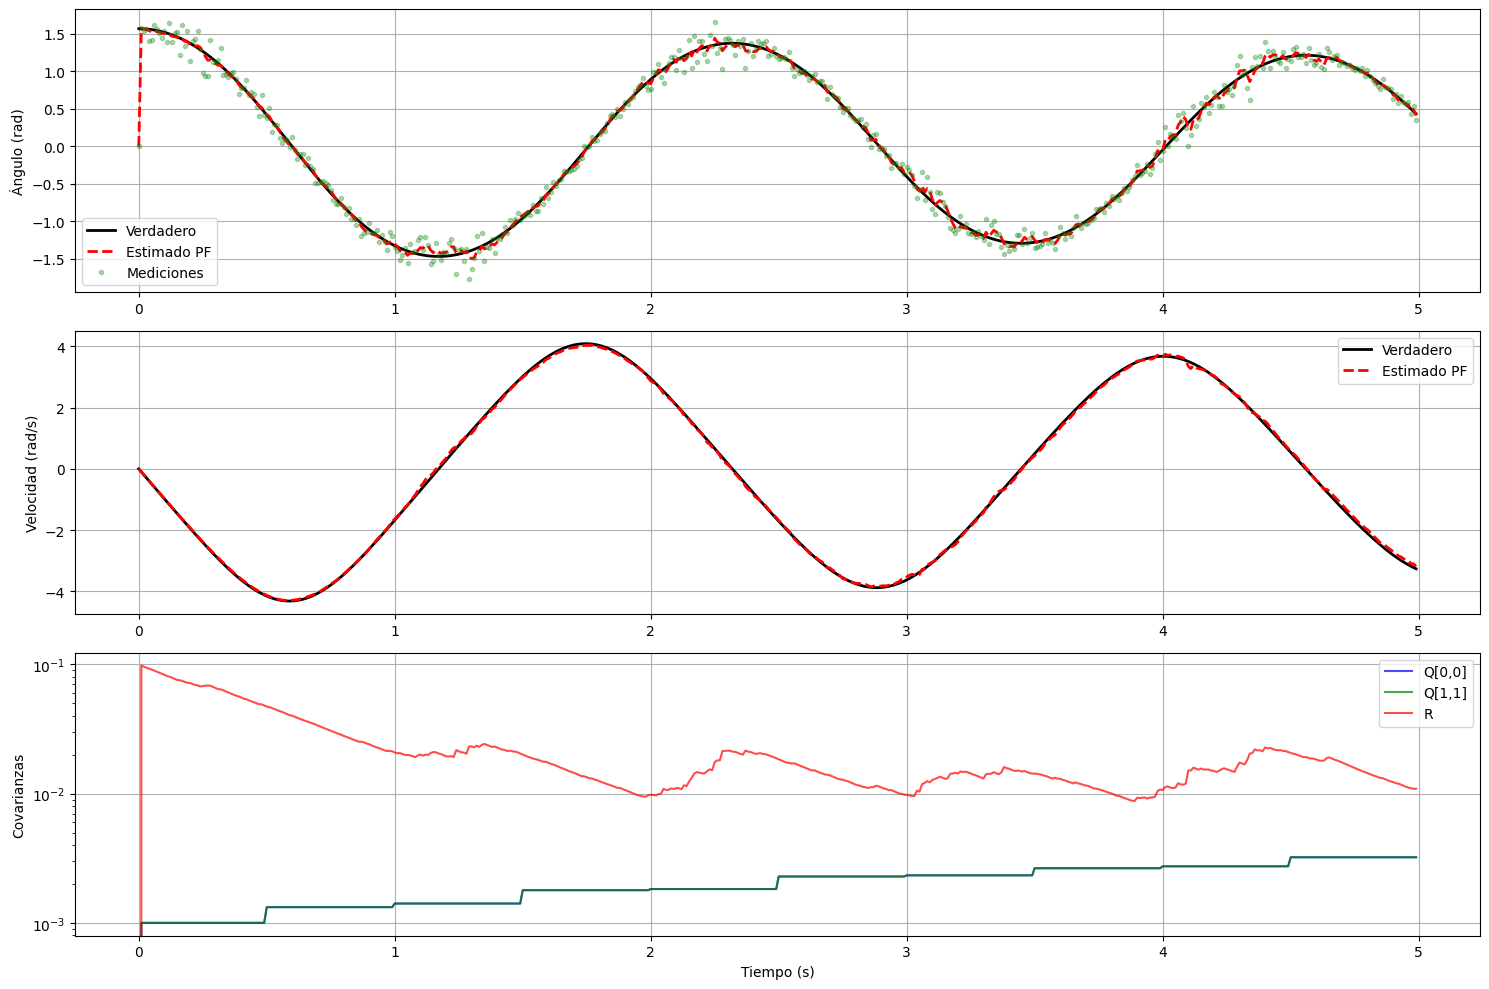

In [25]:
import numpy as np
from numba import jit, prange
import matplotlib.pyplot as plt
import time

@jit(nopython=True)
def system_dynamics_numba(state, params):
    """Modelo del péndulo optimizado"""
    theta, theta_dot = state
    m, l, b, g, u = params
    
    dtheta = theta_dot
    dtheta_dot = (-b/(m*l**2) * theta_dot - 
                  g/l * np.sin(theta) + 
                  1/(m*l**2) * u)
    
    return np.array([dtheta, dtheta_dot])

@jit(nopython=True)
def rk4_step(state, dt, params):
    """Integrador RK4 optimizado"""
    k1 = system_dynamics_numba(state, params)
    k2 = system_dynamics_numba(state + dt*k1/2, params)
    k3 = system_dynamics_numba(state + dt*k2/2, params)
    k4 = system_dynamics_numba(state + dt*k3, params)
    return state + dt*(k1 + 2*k2 + 2*k3 + k4)/6

@jit(nopython=True)
def generate_process_noise(Q_diag, size):
    """Genera ruido del proceso de manera compatible con Numba"""
    return np.random.normal(0.0, 1.0, size) * np.sqrt(Q_diag)

@jit(nopython=True, parallel=True)
def propagate_particles_parallel(particles, params, dt, Q_diag):
    """Propagación paralela de partículas con Q adaptativo"""
    n_particles = len(particles)
    new_particles = np.empty_like(particles)
    
    for i in prange(n_particles):
        # Integración RK4
        new_particles[i] = rk4_step(particles[i], dt, params)
        
        # Ruido del proceso adaptativo
        noise = generate_process_noise(Q_diag, 2)  # Genera ruido para ambos estados
        new_particles[i] += noise
        
        # Normalización del ángulo
        new_particles[i,0] = (new_particles[i,0] + np.pi) % (2 * np.pi) - np.pi
        
    return new_particles

class AdaptiveParticleFilter:
    def __init__(self, num_particles=1000):
        # Parámetros del sistema
        self.m = 1.0
        self.l = 1.0
        self.b = 0.1
        self.g = 9.81
        self.dt = 0.01
        
        # Parámetros del filtro
        self.num_particles = num_particles
        self.particles = np.zeros((num_particles, 2))
        self.weights = np.ones(num_particles) / num_particles
        
        # Inicialización de Q y R adaptativos
        self.Q = np.array([0.001, 0.001])  # Diagonal de Q
        self.R = 0.1
        
        # Parámetros para adaptación
        self.innovation_window = np.zeros(50)
        self.window_size = 50
        self.window_idx = 0
        self.alpha_Q = 0.02
        self.alpha_R = 0.02
        self.min_Q = 1e-6
        self.min_R = 1e-6
        
        # Cache para optimización
        self.system_params = np.array([self.m, self.l, self.b, self.g, 0.0])
    
    def update_Q(self, innovation):
        """Actualización adaptativa de Q"""
        self.innovation_window[self.window_idx] = innovation
        self.window_idx = (self.window_idx + 1) % self.window_size
        
        if self.window_idx == 0:
            innovation_var = np.var(self.innovation_window)
            Q_new = np.maximum(innovation_var * np.ones(2), self.min_Q)
            self.Q = (1 - self.alpha_Q) * self.Q + self.alpha_Q * Q_new
    
    def update_R(self, innovation):
        """Actualización adaptativa de R"""
        innovation_var_short = innovation**2
        R_new = np.maximum(innovation_var_short, self.min_R)
        self.R = (1 - self.alpha_R) * self.R + self.alpha_R * R_new
    
    @staticmethod
    @jit(nopython=True)
    def update_weights_fast(particles, weights, measurement, R):
        """Actualización de pesos optimizada"""
        innovations = measurement - particles[:,0]
        likelihood = np.exp(-0.5 * innovations**2 / R) / np.sqrt(2 * np.pi * R)
        weights *= likelihood
        sum_weights = np.sum(weights)
        if sum_weights > 0:
            weights /= sum_weights
        else:
            weights[:] = 1.0 / len(weights)
        return weights, innovations
    
    @staticmethod
    @jit(nopython=True)
    def systematic_resample_fast(particles, weights):
        """Remuestreo sistemático optimizado"""
        N = len(weights)
        positions = (np.random.random() + np.arange(N)) / N
        cumsum = np.cumsum(weights)
        cumsum[-1] = 1.0
        
        new_particles = np.empty_like(particles)
        i = 0
        j = 0
        while i < N:
            if positions[i] < cumsum[j]:
                new_particles[i] = particles[j]
                i += 1
            else:
                j += 1
                
        return new_particles, np.ones(N) / N
    
    def run_iteration(self, measurement, u=0):
        """Ejecuta una iteración completa del filtro adaptativo"""
        # Actualizar control
        self.system_params[4] = u
        
        # Propagar partículas
        self.particles = propagate_particles_parallel(
            self.particles, self.system_params, self.dt, self.Q)
        
        # Actualizar pesos
        self.weights, innovations = self.update_weights_fast(
            self.particles, self.weights, measurement, self.R)
        
        # Actualizar Q y R
        mean_innovation = np.mean(innovations)
        self.update_Q(mean_innovation)
        self.update_R(mean_innovation)
        
        # Calcular número efectivo de partículas
        Neff = 1.0 / np.sum(self.weights**2)
        
        # Remuestreo si es necesario
        if Neff < self.num_particles/2:
            self.particles, self.weights = self.systematic_resample_fast(
                self.particles, self.weights)
        
        # Estimación del estado
        mean_cos = np.sum(self.weights * np.cos(self.particles[:,0]))
        mean_sin = np.sum(self.weights * np.sin(self.particles[:,0]))
        mean_angle = np.arctan2(mean_sin, mean_cos)
        mean_velocity = np.sum(self.weights * self.particles[:,1])
        
        return np.array([mean_angle, mean_velocity])

def simulate_system():
    """Simulación del sistema"""
    pf = AdaptiveParticleFilter(num_particles=1000)
    t = np.arange(0, 5, pf.dt)
    
    true_states = np.zeros((len(t), 2))
    estimated_states = np.zeros((len(t), 2))
    measurements = np.zeros(len(t))
    Q_history = np.zeros((len(t), 2))
    R_history = np.zeros(len(t))
    
    true_states[0] = [np.pi/2, 0]
    pf.particles = np.random.normal(0, 0.1, (pf.num_particles, 2)) + true_states[0]
    
    start_time = time.time()
    
    for k in range(1, len(t)):
        true_states[k] = rk4_step(true_states[k-1], pf.dt, pf.system_params)
        
        noise_scale = 0.1 * (1 + 0.5*np.sin(2*np.pi*t[k]))
        measurements[k] = true_states[k,0] + np.random.normal(0, noise_scale)
        
        estimated_states[k] = pf.run_iteration(measurements[k])
        
        Q_history[k] = pf.Q
        R_history[k] = pf.R
    
    print(f"Tiempo de ejecución: {time.time() - start_time:.2f} segundos")
    
    return t, true_states, estimated_states, measurements, Q_history, R_history

# Ejecutar simulación y graficar
t, true_states, estimated_states, measurements, Q_history, R_history = simulate_system()

plt.figure(figsize=(15, 10))

plt.subplot(3,1,1)
plt.plot(t, true_states[:,0], 'k-', label='Verdadero', linewidth=2)
plt.plot(t, estimated_states[:,0], 'r--', label='Estimado PF', linewidth=2)
plt.plot(t, measurements, 'g.', label='Mediciones', alpha=0.3)
plt.ylabel('Ángulo (rad)')
plt.legend()
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t, true_states[:,1], 'k-', label='Verdadero', linewidth=2)
plt.plot(t, estimated_states[:,1], 'r--', label='Estimado PF', linewidth=2)
plt.ylabel('Velocidad (rad/s)')
plt.legend()
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(t, Q_history[:,0], 'b-', label='Q[0,0]', alpha=0.7)
plt.plot(t, Q_history[:,1], 'g-', label='Q[1,1]', alpha=0.7)
plt.plot(t, R_history, 'r-', label='R', alpha=0.7)
plt.xlabel('Tiempo (s)')
plt.ylabel('Covarianzas')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()